In [1]:
from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml('mnist_784', version=1)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist['data'], mnist['target']
(X.shape, y.shape)

((70000, 784), (70000,))

### Visualizing data

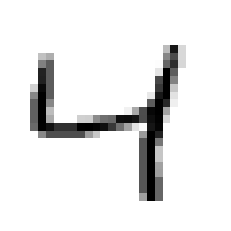

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
some_digit = X[2]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [6]:
import numpy as np 
y = y.astype(np.uint8)
y[2]

4

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Binary classifier of 5

In [8]:
y_train_5 =(y_train==5)
y_test_5 =(y_test==5)

In [9]:
## Classifier
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
sgd_clf.predict([X_train[0],X_train[2]])

array([ True, False])

### Cross validation using custom KFold

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone


In [12]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)

/home/elie/.pyenv/versions/3.7.0/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [13]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
    
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred==y_test_folds)
    print(n_correct/len(y_pred))

0.95035
0.96035
0.9604


### Same Cross Validation with Sklearn

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')


array([0.95035, 0.96035, 0.9604 ])

In [15]:
from sklearn.base import BaseEstimator

In [16]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
never_5_clf = Never5Classifier()

In [17]:
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

### Confusion matrix 

In [18]:
from sklearn.model_selection import cross_val_predict

In [19]:
y_train_5_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [20]:
len(y_train_5_pred), y_train_5_pred.shape, y_train_5_pred[:2]

(60000, (60000,), array([ True, False]))

In [21]:
from sklearn.metrics import confusion_matrix

In [22]:
real_cfm = confusion_matrix(y_train_5, y_train_5_pred)

In [23]:
perfect_pred_y5 = y_train_5
perfect_cfm = confusion_matrix(y_train_5, perfect_pred_y5)
real_cfm

array([[53892,   687],
       [ 1891,  3530]])

In [24]:
precision = real_cfm[1][1] / (real_cfm[1][1] + real_cfm[0][1])
recall = real_cfm[1][1] / (real_cfm[1][1] + real_cfm[1][0])
print("precision = (" , real_cfm[1][1] , "/ ", real_cfm[1][1], "+", real_cfm[0][1] , ") = ",precision)
print("recall = (" , real_cfm[1][1] , "/ ", real_cfm[1][1], "+", real_cfm[1][0] , ") = ", recall)

precision = ( 3530 /  3530 + 687 ) =  0.8370879772350012
recall = ( 3530 /  3530 + 1891 ) =  0.6511713705958311


In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision_skl = precision_score(y_train_5, y_train_5_pred)
recall_skl = recall_score(y_train_5, y_train_5_pred)
f1_score_skl = f1_score(y_train_5, y_train_5_pred)
print('precision = ',precision_skl,'recall =',recall_skl, 'f1_score = ', f1_score_skl)

precision =  0.8370879772350012 recall = 0.6511713705958311 f1_score =  0.7325171197343846


In [26]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [27]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [35]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.legend(loc='center right', fontsize=16)
    plt.grid(True)
    plt.axis([-50000,50000,0,1])
    

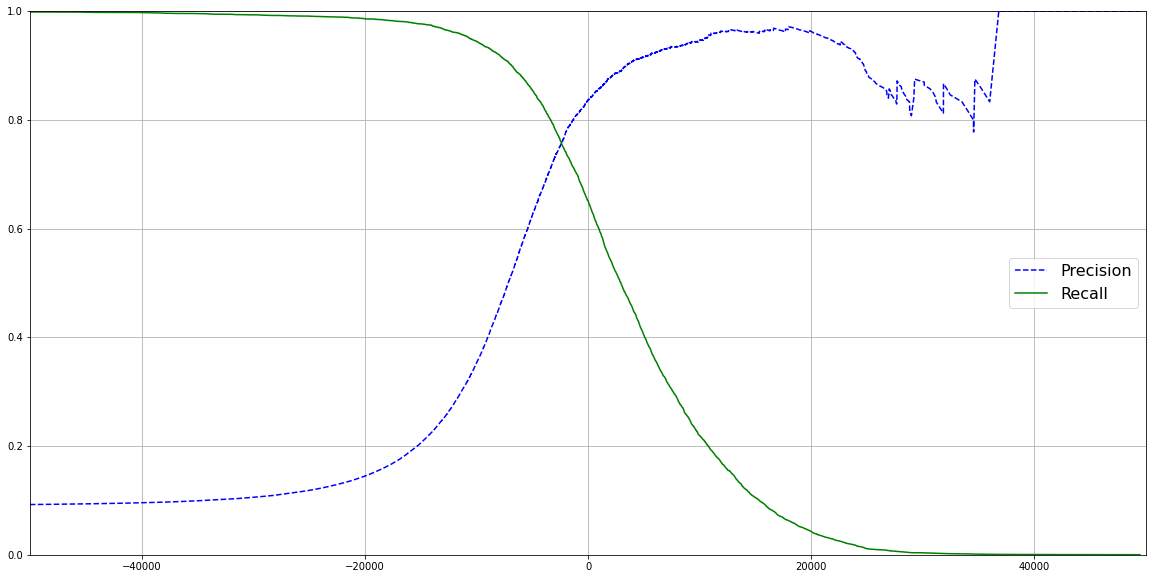

In [36]:
plt.figure(figsize=(20,10))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

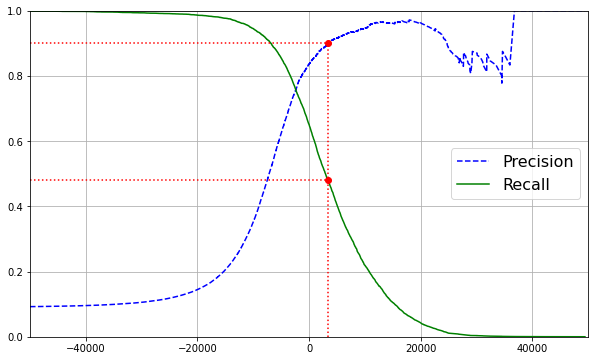

In [52]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)]
recall_90_precision, threshold_90_precision
plt.figure(figsize=(10,6))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0,.9],"r:")
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")  
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
                                              # Not shown
plt.show()

In [56]:
y_train_pred_90 =(y_scores >= threshold_90_precision)

precision_scr = precision_score(y_train_5, y_train_pred_90)
recall_scr = recall_score(y_train_5, y_train_pred_90)
precision_scr, recall_scr


(0.9000345901072293, 0.4799852425751706)

### Precision vs recall tradeoff graph

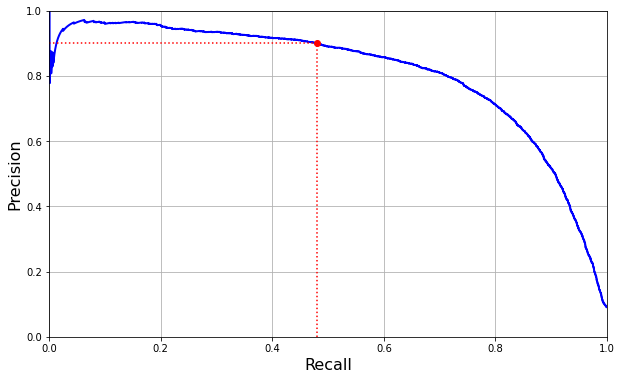

In [66]:
plt.figure(figsize=(10,6))
plt.plot(recalls, precisions,  "b-", linewidth=2)
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()